In [20]:
import pandas as pd # for read data
import numpy as np  # for numerical python libraries
import scipy.stats as st  # for statistical libraries
import matplotlib.pyplot as plt  # for plotting
import csv # for csv import
import math
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

from numpy import genfromtxt
import matplotlib.pylab as pylab
import os   
import glob
from sklearn.metrics import confusion_matrix

np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

In [21]:
path = r'Data-1'
allfiles = sorted(glob.glob(path + "/*.csv"))

data = []

for file in allfiles:
    data.append(pd.read_csv(file, index_col=None, header=None, skiprows=20,skipfooter=21,
                      names=["T", "QV", "P", 
                          "NB","NS","VB","VS"], engine='python'))
del data[-6]
def appendx(data1,feature):
    x = np.array(())
    for i in range(len(data)):
        x = np.append(x,np.asarray(data[i][feature]))
    return x
    
QV = appendx(data,'QV') 
P = appendx(data,'P') 
NB = appendx(data,'NB') 
NS = appendx(data,'NS') 
VB = appendx(data,'VB') 
VS = appendx(data,'VS') 

def trans(QV): 
    return np.sqrt(QV/np.mean(QV))

seq_QV_trans = [0]*len(data)
for i in range(len(data)):
    seq_QV_trans[i] = trans(data[i]["QV"])
    data[i]["QV_trans"] = seq_QV_trans[i]
QV_trans=appendx(data,'QV_trans')
print(data[1]["QV_trans"])
print(len(data))


0       2.656496
1       0.000000
2       1.936238
3       0.664124
4       2.271654
          ...   
2295    0.420029
2296    0.785802
2297    0.297005
2298    0.420029
2299    0.594011
Name: QV_trans, Length: 2300, dtype: float64
20


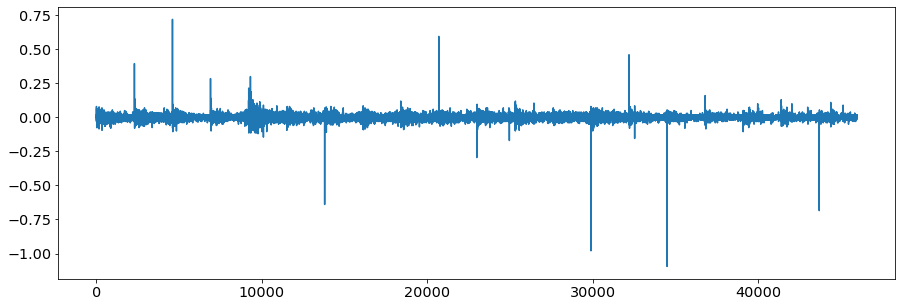

In [22]:
t = np.linspace(1,len(P),num=len(P))
price = pd.Series(P)
pchange=price.diff()
pchange[0]=0
plt.plot(t,pchange)

-1.0


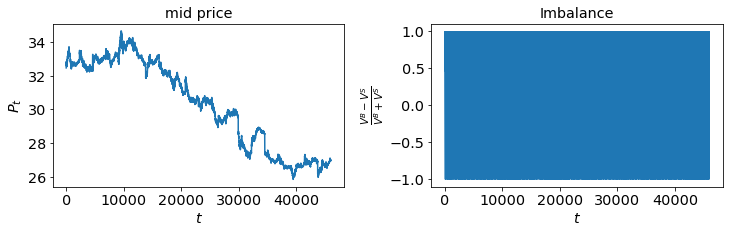

In [23]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(t,P)
plt.xlabel(r'$t$')    
plt.ylabel(r'$P_t$')
plt.title('mid price')

plt.subplot(1,2,2)
rho = (VB-VS)/(VB+VS)
rho[(VB+VS)==0] = 0
plt.plot(t,rho,linewidth=0.2)
plt.xlabel(r'$t$')    
plt.ylabel(r'$\frac{V^B-V^S}{V^B+V^S}$')
plt.title('Imbalance')
print(np.min(rho))
plt.subplots_adjust(wspace=0.3)
plt.show()


10.419905134996917
0.05405


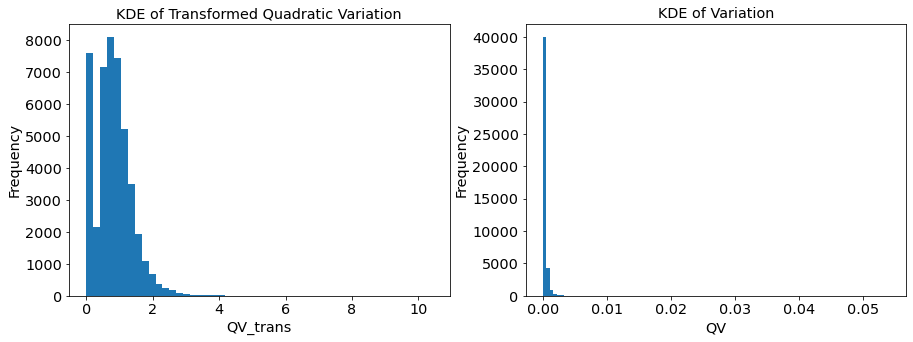

0.00029299184782608694


In [24]:
plt.subplot(1,2,1)
print(max(QV_trans))
plt.hist(QV_trans,bins=50)
plt.title("KDE of Transformed Quadratic Variation")
plt.xlabel('QV_trans')
plt.ylabel('Frequency')
plt.ylim=(0,0.005)
plt.subplot(1,2,2)
print(max(QV))
plt.hist(QV,bins=100)
plt.title("KDE of Variation")
plt.ylabel('Frequency')
plt.xlabel('QV')
plt.ylim=(0,0.005)
plt.show()
print(np.mean(QV))

In [25]:
# standardize features...
def Normalize(x, p):
    # linear transformation to make 
    #   P(a X +b < -1 ) = p
    #   P(a X +b > 1 ) = p

    q = np.quantile(x,[p, 1-p])
    a = 2.0 /(q[1]-q[0])
    b = 1.0 - a * q[1]
    
    return a*x+b 

def LogNormalize(x, p):
    
    y = np.log(1 + x / np.mean(x[x!=0],axis=0) )
    
    return Normalize(y, p)

def NormalizeFeatures(QV,P,NB,NS,VB,VS,QV_trans, p):

    x = np.empty((P.shape[0], 9))
    x[1:,0] = P[1:]-P[:-1]
    x[0,0] = 0
    x[:,0] = Normalize(x[:,0], p)
    x[:,1] = Normalize(P, p)
    x[:,2] = LogNormalize(NB, p)
    x[:,3] = LogNormalize(NS, p)
    x[:,4] = LogNormalize(VB,p)
    x[:,5] = LogNormalize(VS,p)
    x[:,6] = LogNormalize(QV,p) 
    # order-imbalance
    rho = (VB-VS)/(VB+VS)
    rho[(VB+VS)==0] = 0
    x[:,7] = Normalize(rho,p)
    x[:,8] = LogNormalize(QV_trans,p)
    return x

0.7418477005059857


Text(0.5, 1.0, 'KDE Quadratic Variation')

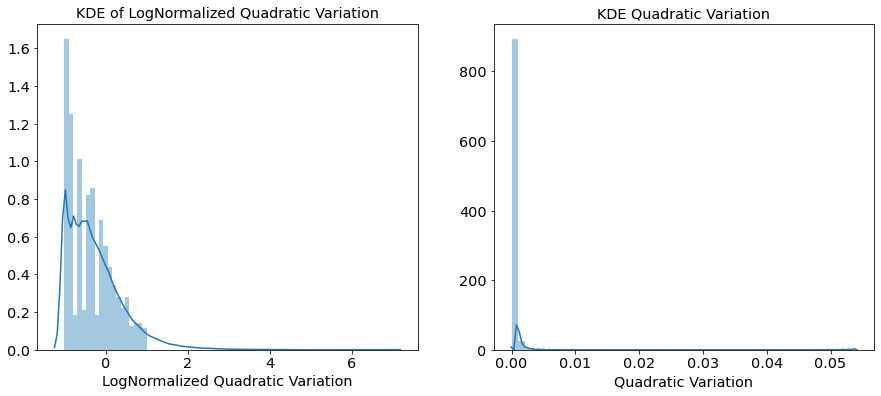

In [27]:
x = NormalizeFeatures(QV,P,NB,NS,VB,VS,QV_trans,0.05)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.distplot(x[:,6],bins=(np.linspace(-1,1,20)),  kde=True, hist=True)
print(np.mean(x[:,6])+1)
plt.xlabel('LogNormalized Quadratic Variation')
plt.title("KDE of LogNormalized Quadratic Variation")
plt.subplot(1,2,2)
sns.distplot(QV,bins=50,  kde=True, hist=True)
plt.xlabel('Quadratic Variation')
plt.title("KDE Quadratic Variation")

Let's generate histograms of the normalized or lognormalized features to get a general idea of the their distributions and then do more analysis on the data. Additionally, Normalizing and Lognormalizing the features would not change the distributions that the original data follows, this data transformation would give us a better visualization to investigate the univariate distributions of each features.
- the First Change of Price

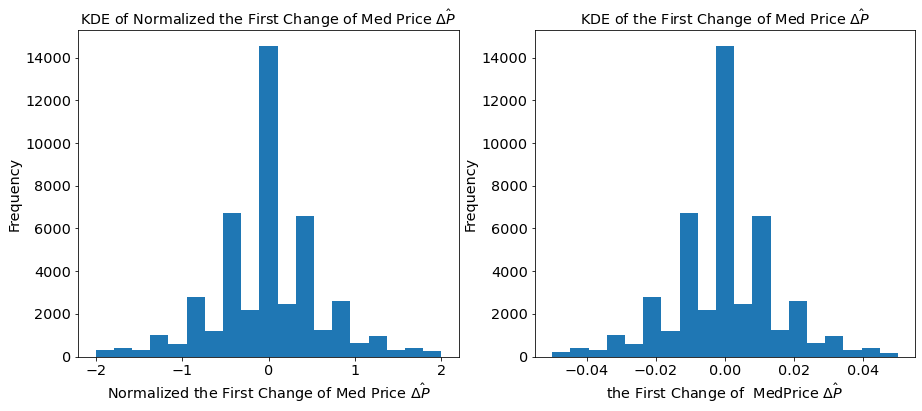

In [29]:
# Histograms of Normalized the First Change of Price
x = NormalizeFeatures(QV,P,NB,NS,VB,VS,QV_trans,0.05)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.hist(x[:,0],bins=(np.linspace(-2,2,20)))
plt.ylabel('Frequency')
plt.xlabel('Normalized the First Change of Med Price $\hat{\Delta P}$')
plt.title("KDE of Normalized the First Change of Med Price $\hat{\Delta P}$")
plt.subplot(1,2,2)
plt.hist(pchange,bins=(np.linspace(-0.05,0.05,20)))
plt.ylabel('Frequency')
plt.xlabel('the First Change of  MedPrice $\hat{\Delta P}$')
plt.title("KDE of the First Change of Med Price $\hat{\Delta P}$")

plt.show()

- Mid Price

Text(0, 0.5, 'QV')

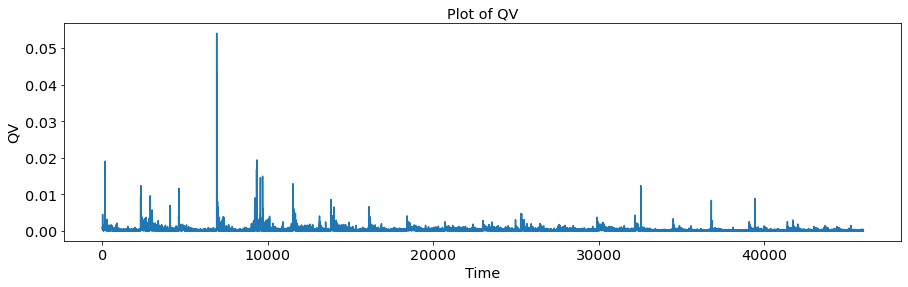

In [30]:
plt.figure(figsize=(15,4))
plt.plot(QV)
plt.title("Plot of QV")
plt.xlabel("Time")
plt.ylabel("QV")

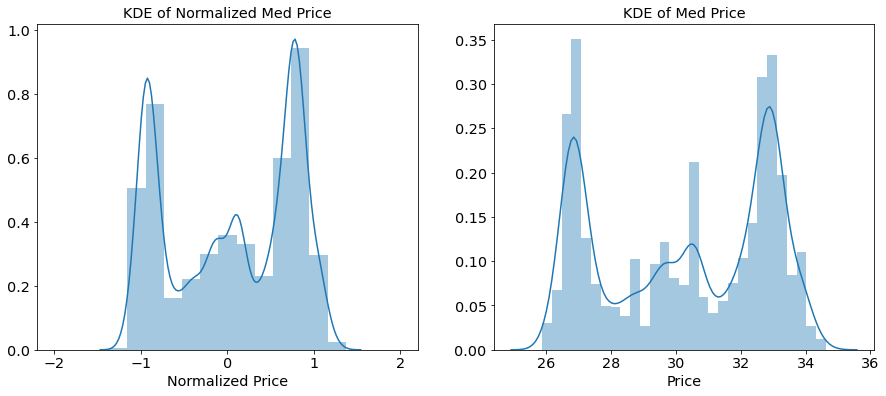

In [31]:
# Histograms of Normalized Price

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.distplot(x[:,1],bins=(np.linspace(-2,2,20)),  kde=True, hist=True)
plt.title("KDE of Normalized Med Price")

plt.xlabel('Normalized Price')
plt.subplot(1,2,2)
sns.distplot(P,  hist=True)
plt.title("KDE of Med Price")
plt.xlabel('Price')

plt.show()

Mid Price seems to be a Multinormal Distribution with three normal peaks which are around 27, 30.5 and 33 respectively in orginal data set Mid Price. Meanwhile, from the normalized plot, it gives consistent results.\
From the plot of Med Price, we can see it looks like a time series with a downward trend and fluctuations. Next, we plot the first difference of Med Price to see if it is stationay. 
- Number of Market Buys

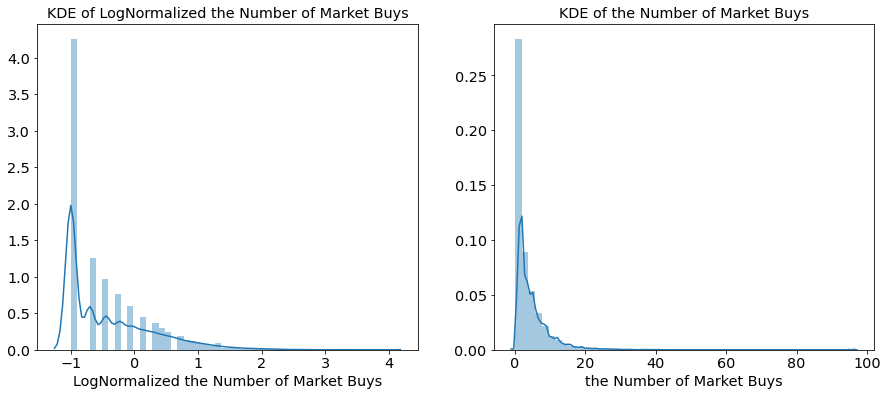

0.577956169235958
3.9255462580699874


In [32]:
# Histograms of LogNormalized the Number of Buys
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.distplot(x[:,2],  kde=True, hist=True)

plt.xlabel('LogNormalized the Number of Market Buys')
plt.title("KDE of LogNormalized the Number of Market Buys")
plt.subplot(1,2,2)
sns.distplot(NB,  kde=True, hist=True)

plt.xlabel('the Number of Market Buys')
plt.title("KDE of the Number of Market Buys")
plt.show()
np.max(NB)
print(np.mean(x[:,2])+1)
print(np.max(x[:,2]))

The number of buys is discerete and positive counting data. From the plot above, it seems to follow a poissson distribution with $\lambda$ apporximately close to 3. The maximum number of buys is 96 which may happen at the very beginning of the market or end of the market. Meanwhile, a large number of data is at 0 which means there is no trading in this market at most of time.
- the Number of Market Sells

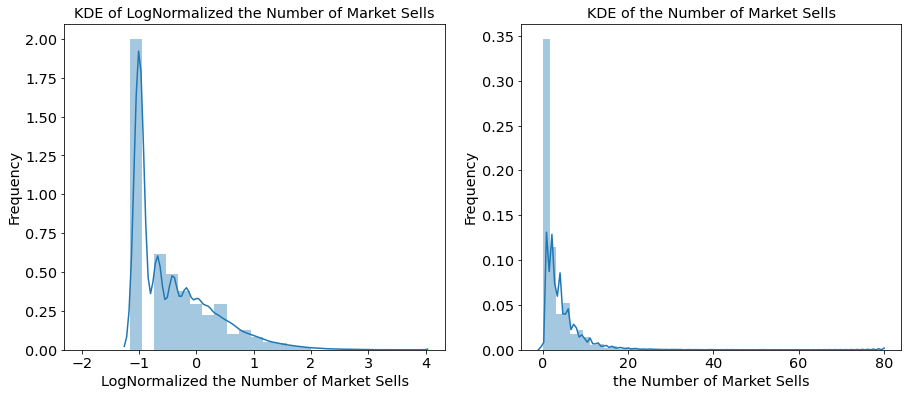

0.5858166222636385
3.7759165969138477


In [33]:
# Histograms of Normalized the Number of Sells
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.distplot(x[:,3],bins=(np.linspace(-2,2,20)),  kde=True, hist=True)
plt.ylabel('Frequency')
plt.xlabel('LogNormalized the Number of Market Sells')
plt.title("KDE of LogNormalized the Number of Market Sells")
plt.subplot(1,2,2)
sns.distplot(NS,bins=50,  kde=True, hist=True)
plt.ylabel('Frequency')
plt.xlabel('the Number of Market Sells')
plt.title("KDE of the Number of Market Sells")
plt.show()
print(np.mean(x[:,3])+1)
print(np.max(x[:,3]))

The number of sells is discerete and positive counting data. From the plot above, it seems to follow a poissson distribution with $\lambda$ apporximately close to 2.78. The maximum number of sells is 979 which may happen at the very beginning of the market or end of the market. Meanwhile, a large number of data is at 0 which means there is no trading in this market at most of time.
- the Volume of Market Buys

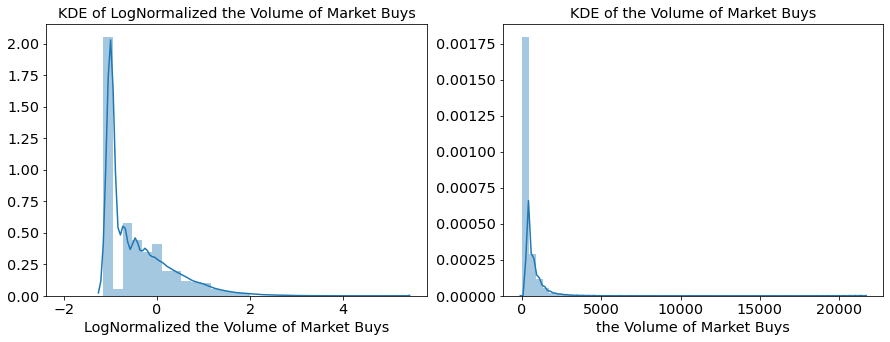

0.5630055485902212
5.166997012975059


In [34]:
# Histograms of LogNormalized the Volume of Market Buys
plt.subplot(1,2,1)
sns.distplot(x[:,4],bins=(np.linspace(-2,2,20)),  kde=True, hist=True)

plt.xlabel('LogNormalized the Volume of Market Buys')
plt.title("KDE of LogNormalized the Volume of Market Buys")
plt.subplot(1,2,2)
sns.distplot(VB, bins=50,kde=True, hist=True)
plt.title("KDE of the Volume of Market Buys")
plt.xlabel('the Volume of Market Buys')
plt.show()
print(np.mean(x[:,4])+1)
print(np.max(x[:,4]))

Volume of Buys and Volume of Sells are discrete and positive counting data so they are poisson once again. From the Volume of Buys plot, even with most of the data points concentrated around 0, the estimated parameter $\lambda$ is over 300. This is because there are several points with large volume of buys (the maximum number of buys is 21600). Meanwhile,from the Volume of Sells plot, the estimated parameter $\lambda$ is around 300 and the maximum value is over 25000. Thus, we may consider to do more investigation on Data selection since those points may be considered as outliers.
- the Volume of Market Sells

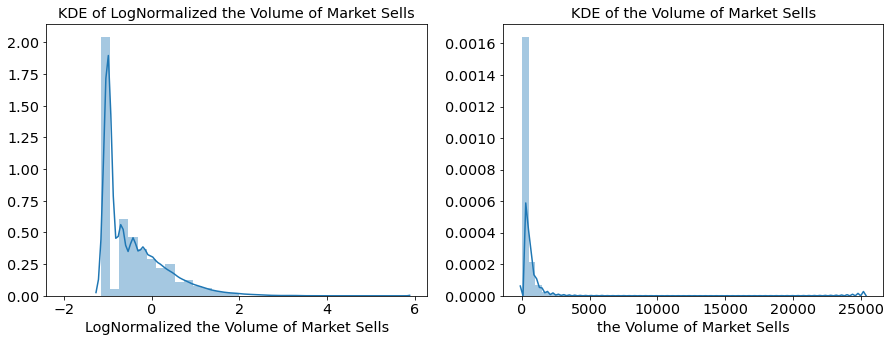

0.5718622537752178
5.61628200182961


In [35]:
# Histograms of LogNormalized the Volume of Market Sells
plt.subplot(1,2,1)
sns.distplot(x[:,5],bins=(np.linspace(-2,2,20)),  kde=True, hist=True)

plt.xlabel('LogNormalized the Volume of Market Sells')
plt.title("KDE of LogNormalized the Volume of Market Sells")
plt.subplot(1,2,2)
sns.distplot(VS,  bins=50,kde=True, hist=True)
plt.title("KDE of the Volume of Market Sells")
plt.xlabel('the Volume of Market Sells')
plt.show()
print(np.mean(x[:,5])+1)
print(np.max(x[:,5]))

- QV

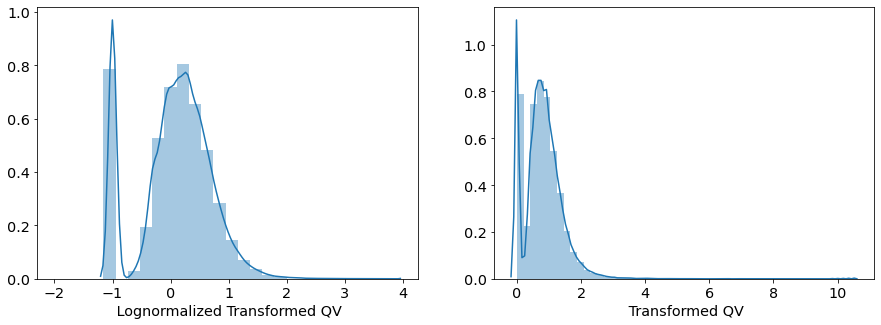

In [36]:
# Histograms of Lognormalized Transformed QV
plt.subplot(1,2,1)
sns.distplot(x[:,8],bins=(np.linspace(-2,2,20)),  kde=True, hist=True)

plt.xlabel(' Lognormalized Transformed QV')
plt.subplot(1,2,2)
sns.distplot(QV_trans, kde=True, hist=True)
plt.xlabel(' Transformed QV')
plt.show()

Text(0.5, 0, 'Normalized $\\hat{I}mbalance$')

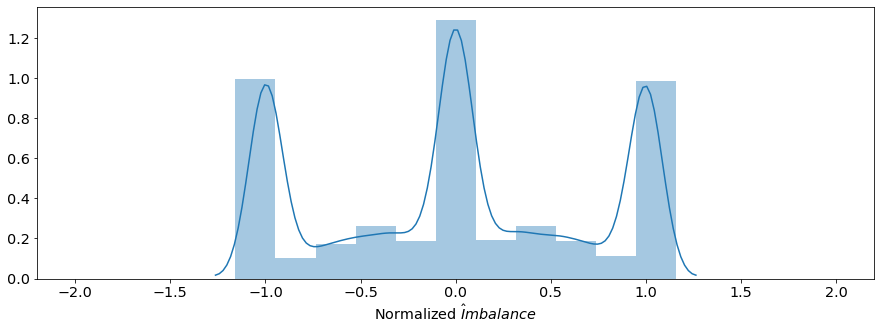

In [37]:
# Histograms of Normalized Imbalance

sns.distplot(x[:,7], bins=(np.linspace(-2,2,20)), kde=True, hist=True)
plt.xlabel('Normalized $\hat{I}mbalance$')

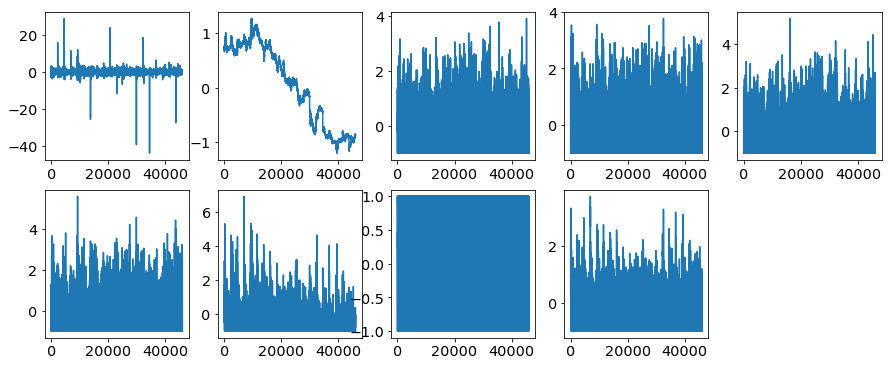

In [38]:
# show features as a time-series
plt.figure(figsize=(15,6))
for k in range(x.shape[1]):
    plt.subplot(2,5,k+1)
    plt.plot(x[:,k])

plt.show()

In [39]:
import pandas as pd # for read data
import numpy as np  # for numerical python libraries
import scipy.stats as st  # for statistical libraries
import matplotlib.pyplot as plt  # for plotting
import csv # for csv import
import math
import seaborn as sns
import warnings
import torch.optim as optim
warnings.filterwarnings('ignore')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

from numpy import genfromtxt
import matplotlib.pylab as pylab
import os   
import glob
from sklearn.metrics import confusion_matrix,accuracy_score
from random import *


np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

### One-step MC & Two-step MC

In [40]:
def plot_conf_mat(conf_mat, classes):

    fig = plt.figure(figsize=(12,15))
    
    ax = plt.subplot(1,2,1)
    
    ax.imshow(conf_mat, interpolation='nearest', cmap = plt.cm.Blues)
    
    ax.set(xticks=np.arange(conf_mat.shape[1]),
           yticks=np.arange(conf_mat.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    fmt = 'd'
    thresh = conf_mat.max() / 2.
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            ax.text(j, i, format(conf_mat[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat[i, j] > thresh else "black") 
    
    
    conf_mat_nrm = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]
    
    ax = plt.subplot(1,2,2)
    
    ax.imshow(conf_mat_nrm, interpolation='nearest', cmap = plt.cm.Blues)
    
    ax.set(xticks=np.arange(conf_mat_nrm.shape[1]),
           yticks=np.arange(conf_mat_nrm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    
    fmt = '.2f'
    thresh = conf_mat_nrm.max() / 2.
    for i in range(conf_mat_nrm.shape[0]):
        for j in range(conf_mat_nrm.shape[1]):
            ax.text(j, i, format(conf_mat_nrm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_mat_nrm[i, j] > thresh else "black")
            
            
    fig.tight_layout()      
    
    plt.show()



In [41]:
path = r'Data-1'
allfiles = sorted(glob.glob(path + "/*.csv"))

data = [] #to store the information everyday, each element is a dataframe dimension(2300,7)

for file in allfiles:
    data.append(pd.read_csv(file, index_col=None, header=None,skiprows=1,skipfooter=1,
                      names=["T", "QV", "P", 
                             "NB","NS","VB","VS"], engine='python'))


    
del data[-6]
QV=np.empty((len(data), data[0].shape[0]))

for i in range(len(data)):
    QV[i,:]=data[i]['QV']
    

QV=np.delete(QV,-1,axis=1)
QV.shape

(20, 2338)

In [42]:
T=np.empty((len(data), data[0].shape[0]))

for i in range(len(data)):
    T[i,:]=data[i]['T']

QV=np.empty((len(data), data[0].shape[0]))

for i in range(len(data)):
    QV[i,:]=data[i]['QV']
    
P=np.empty((len(data), data[0].shape[0]))

for i in range(len(data)):
    P[i,:]=data[i]['P']
NB=np.empty((len(data), data[0].shape[0]))

for i in range(len(data)):
    NB[i,:]=data[i]['NB']
NS=np.empty((len(data), data[0].shape[0]))

for i in range(len(data)):
    NS[i,:]=data[i]['NS']
VB=np.empty((len(data), data[0].shape[0]))

for i in range(len(data)):
    VB[i,:]=data[i]['VB']
VS=np.empty((len(data), data[0].shape[0]))

for i in range(len(data)):
    VS[i,:]=data[i]['VS']

In [43]:
# standardize features...
def Normalize(x, p):
    # linear transformation to make 
    #   P(a X +b < -1 ) = p
    #   P(a X +b > 1 ) = p

    for i in range(x.shape[0]):
        q = np.quantile(x,[p, 1-p])
        a = 2.0 /(q[1]-q[0])
        b = 1.0 - a * q[1]
        x[i,:]=a*x[i,:]+b
    
    return x

def LogNormalize(x, p):
    y=np.zeros(x.shape)
    
    for i in range(x.shape[0]):
        y[i,:] = np.log(1 + x[i,:] / np.mean((x[i,:]!=0)*(x[i,:])))
    
    return Normalize(y, p)



In [44]:
# def GenerateTargets(QV,  mRegimes):
    
#     # future price changes over m-steps
#     p = 1/mRegimes * np.arange(1,mRegimes)
#     qtl = np.quantile(QV, p)
    
#     y = np.zeros(len(QV)).astype(int)
#     y[QV<qtl[0]] = 0 
    
#     for i in range(1,len(qtl)):
#         y[(QV>=qtl[i-1])&(QV<qtl[i])] = i
        
#     y[QV>=qtl[-1]] = mRegimes-1
#     y.astype(int)
    
#     return y

In [45]:
def GenerateQtl(QV,  mRegimes):
    
     # future price changes over m-steps
    p = 1/mRegimes * np.arange(1,mRegimes)
    q = np.zeros((mRegimes-1, QV.shape[-1]))
    
    for i in range(QV.shape[1]):
        qtl = np.quantile(QV[:,i], p)
        q[:,i] = qtl
    return q
    
def GenerateTargets(QV, qtl, mRegimes):  
    
    n = np.size(QV,0)
    y = np.zeros((n,QV.shape[-1]))
    for i in range(n):
        for j in range(QV.shape[-1]):
            if QV[i,j] <= qtl[0,j]:
                y[i,j] = 0
            
            elif QV[i,j] > qtl[0,j] and QV[i,j] <= qtl[1,j]:
                y[i,j] = 1
                
            elif QV[i,j] > qtl[1,j] and QV[i,j] <= qtl[2,j]:
                y[i,j] = 2
                
            elif QV[i,j] > qtl[2,j] and QV[i,j] <= qtl[3,j]:
                y[i,j] = 3
            
            else:
                y[i,j] = 4
    y[:,0] = 0
    
    return y

qtl = GenerateQtl(QV,  5)
label = GenerateTargets(QV, qtl, 5)

In [46]:
#random guess the labels
# label=np.zeros(np.shape(QV))
# for i in range(QV.shape[1]):
#     label[:,i] = GenerateTargets(QV[:,i],5)


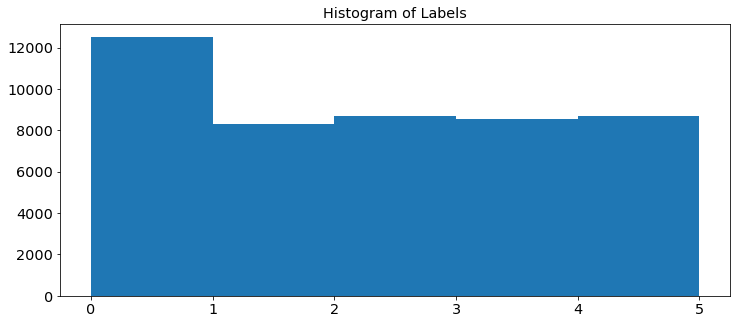

In [47]:
plt.figure(figsize=(12,5))
plt.hist(pd.DataFrame(label).stack().values, np.arange(0,6))
plt.title("Histogram of Labels")
plt.xlabel="Label"
plt.ylabel="Frequency"
plt.show()

Text(0.5, 1.0, 'Diurnal Pattern of QV ')

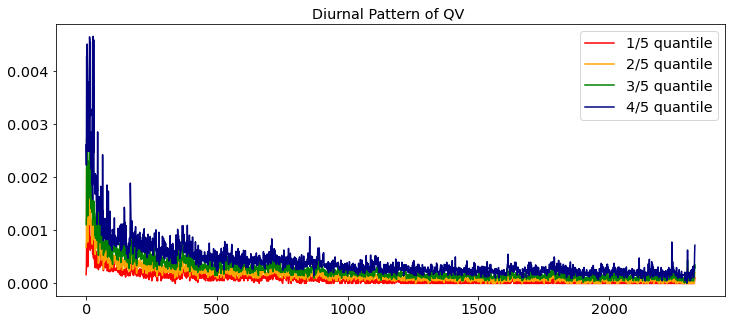

In [48]:
plt.figure(figsize=(12,5))
plt.plot(qtl[0,10:],color='red', label='1/5 quantile')
plt.plot(qtl[1,10:],color='orange', label='2/5 quantile')
plt.plot(qtl[2,10:],color='green', label='3/5 quantile')
plt.plot(qtl[3,10:],color='navy', label='4/5 quantile')
plt.legend()
plt.xlabel="Time"
plt.ylabel="Transformed QV"
plt.title("Diurnal Pattern of QV ")

In [49]:
def onestep(df,mRegimes):
    
    A = np.zeros((mRegimes,mRegimes))
    
    for i in range(df.shape[0]):
        for j in range(df.shape[1]-1):
            A[df[i,j].astype(int), df[i,j+1].astype(int)] += 1
            
    A /= A.sum(axis = 1, keepdims=1)
    
    return A

def onestepPredict(test,mRegimes,A):
    y=np.zeros(test.shape).astype(int)
    y[0]=test[0]
    for i in range(1, len(y)):
        y[i]=A[test[i-1].astype(int)].argmax()
    return y
        

In [50]:
def twostep(df, mRegimes):
    
    A = np.zeros((mRegimes,mRegimes,mRegimes))
    
    for i in range(df.shape[0]):
        for j in range(df.shape[1]-2):
            A[df[i,j].astype(int), df[i,j+1].astype(int), df[i,j+2].astype(int)] += 1
            
    A /= A.sum(axis = 2, keepdims=1)
    
    return A

def twostepPredict(test,mRegimes,A):
    y=np.zeros(test.shape)
    y[0]=test[0]
    y[1]=test[1]
    for i in range(2, len(test)-1):
        y[i]=A[test[i-2].astype(int),test[i-1].astype(int)].argmax()
    return y
        
        

predict the last day 

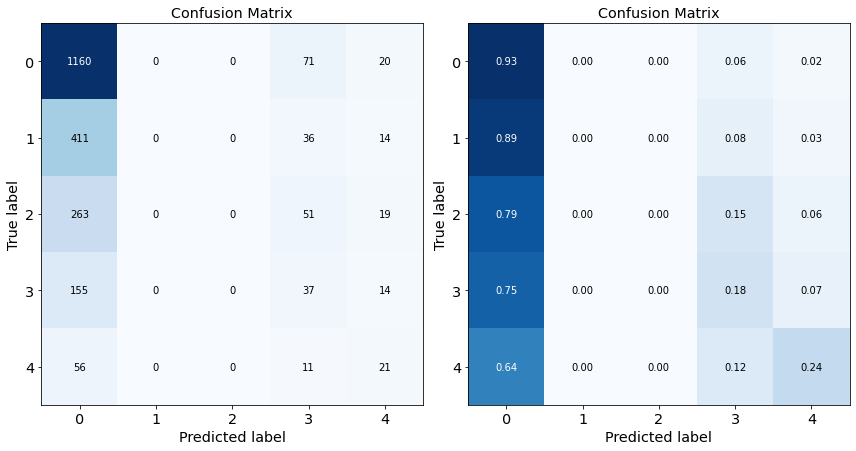

In [51]:
train=label[:-1,:]
test=label[-1]
A_one=onestep(train,5)
#pred_one=onestepPredict(test,5,A_one)
one_predict=onestepPredict(test,5,A_one)
conf_mat=confusion_matrix(test,one_predict)
plot_conf_mat(conf_mat,['0','1','2','3','4','5'])

#print('The prediction accuracy on the last day with one-step MC is: '+str(OneMC_accuracy(test,pred_one)))

#A_two=twostep(train,5)
#pred_two=twostepPredict(test,5,A_two)
#print('The prediction accuracy on the last day with two-step MC is: '+str(TwoMC_accuracy(test,pred_two)))


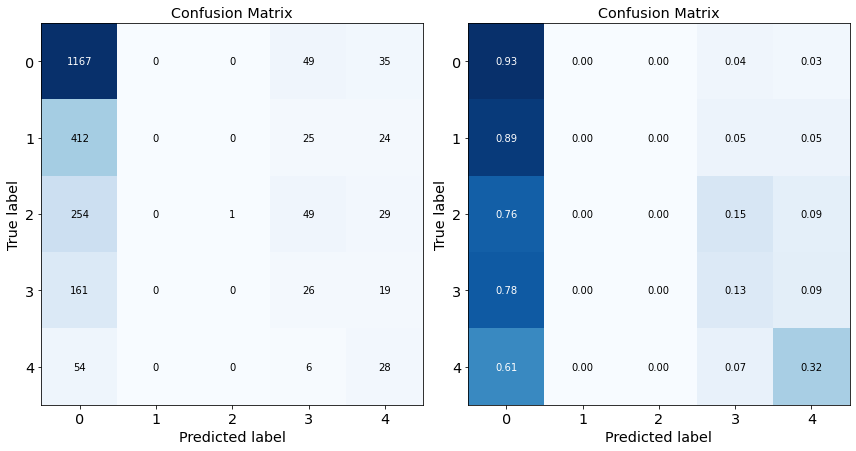

In [52]:
A_two=twostep(train,5)
two_pred=twostepPredict(test,5,A_two)
conf_mat=confusion_matrix(test,two_pred)
plot_conf_mat(conf_mat,['0','1','2','3','4','5'])

perform LOOCV

In [53]:
def oneLOOCV(df,mRegimes):
    
    Accuracy=np.zeros(df.shape[0])

    for n in range(df.shape[0]):
        train=np.delete(label,n,axis=0)
        test=label[n]
        A=onestep(train,mRegimes)
        pred=onestepPredict(test,mRegimes,A)

        acc = accuracy_score(test, pred)
        Accuracy[n]=acc  

    return Accuracy


def twoLOOCV(df,mRegimes):
    Accuracy=np.zeros(df.shape[0])
    for n in range(df.shape[0]):
        train=np.delete(label,n,axis=0)
        test=label[n]
        A=twostep(train,mRegimes)
        pred=twostepPredict(test,mRegimes,A)
        
        acc = accuracy_score(test, pred)
        
        Accuracy[n]=acc
    
    return Accuracy


In [54]:
oneLOOCV(label,5)

array([0.26678, 0.36383, 0.29885, 0.28944, 0.32792, 0.31723, 0.2826 ,
       0.29201, 0.24198, 0.26635, 0.28645, 0.32664, 0.24797, 0.26336,
       0.3339 , 0.51176, 0.41257, 0.39419, 0.43395, 0.52074])

In [55]:
np.mean(oneLOOCV(label,5))

0.333924754168448

In [56]:
np.mean(twoLOOCV(label,5))

0.34142796066695164

### NN

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyNet(nn.Module):
    
    def __init__(self, nlags, nNodes, mRegimes, nfeatures ):
        super(MyNet, self).__init__()
        
        # 5 x nlags input layer, mRegimes output channels (QV),        2 hidden layers with nUnits units each
        self.f_in_to_h1 = nn.Linear( nfeatures * nlags, nNodes) #features (5) * lags
        self.f_h1_to_h2 = nn.Linear(nNodes, nNodes) #from layer 1 to layer 2
        self.f_h2_to_h3 = nn.Linear(nNodes, nNodes)
        self.f_h3_to_out = nn.Linear(nNodes, mRegimes)

    def forward(self, x):
        
#        # input into 1st hidden layer
        h1 = torch.sigmoid(self.f_in_to_h1(x))
        
#        # 1st hidden to 2nd hidden layer
        h2 = torch.relu(self.f_h1_to_h2(h1))
        h3 = torch.relu(self.f_h2_to_h3(h2))

        y = self.f_h3_to_out(h3)
        
        return y

In [58]:
def GetMinibatch(i, sample, MinibatchSize, nlags,nfeatures,day):
    # grab a minibatch starting at i and using all features from nlags
    
#     day=randint(0,sample.shape[0]-1) #randomly pick a day
    
    xb = np.empty((MinibatchSize, nlags*nfeatures))
    
    for k in range(0,MinibatchSize):

        xb[k,:] = np.reshape(sample[day,i+k-nlags:i+k,:],(1, nfeatures*nlags))
    
    yb = label[day,i:i+MinibatchSize].T  
    
    return xb, yb

#### LOOCV NN

In [86]:
def NN_LOOCV(MinibatchSize,nlags,nfeatures,mRegimes,nnode,x):

    Accuracy = []
#     loss_hist = []
#     loss_mean=[]

    for test_day in range(20):
        
        net = MyNet(nlags, nnode, mRegimes,nfeatures)
        optimizer = optim.Adam(net.parameters())
        criterion = nn.CrossEntropyLoss()
        Nepochs = 200

        for epoch in range(Nepochs):
            
            for train_day in range(20):
                
                if train_day != test_day:

    #         idx = np.floor(np.random.uniform()* MinibatchSize + nlags).astype(int)   #create a random index, need to incoporate the lags

                    xb, yb = GetMinibatch(nlags,x, MinibatchSize, nlags,nfeatures,train_day)

                    inputs = torch.tensor(xb, dtype=torch.float)  

                    targets =  torch.tensor(yb, dtype=torch.long) 

                    optimizer.zero_grad()

                    outputs = net(inputs)

                    loss = criterion(outputs, targets)

                    loss.backward()

                    optimizer.step()

#         loss_hist.append(  loss.item() )
    
        xb, yb = GetMinibatch(nlags, x, MinibatchSize, nlags,nfeatures, test_day)
        inputs = torch.tensor(xb, dtype=torch.float)
        outputs = net(inputs) 
        expfac =  np.minimum( np.exp(outputs.detach().numpy()), 1e200)   #outputs.detch().numpy() is to remove tensor and make it numpy object
        prob = expfac / np.sum( expfac, axis=1).reshape(-1,1)
        y_pred = np.argmax(prob, axis=1)
#         testing_conf_mat = confusion_matrix(yb, y_pred)
#         testing_error = 1 - np.diag(testing_conf_mat).sum() / testing_conf_mat.sum()
        acc = accuracy_score(yb, y_pred)
        print('Accuracy with testing day ' + str(int(test_day+1)) + ' : ' + str(acc))
        Accuracy.append(acc)

    return  Accuracy



In [87]:
# QV trans
p=0.05
x = np.empty((P.shape[0], P.shape[1],6))
x[1:,:,0] = P[1:,:]-P[:-1,:]
x[0,:,0] = 0
x[:,:,0] = Normalize(x[:,:,0], p)
x[:,:,1] = LogNormalize(VB, p)
x[:,:,2] = LogNormalize(VS, p)
x[:,:,3] = LogNormalize(trans(QV),p)
x[:,:,4] = LogNormalize(NB, p)
x[:,:,5] = LogNormalize(NS, p)

In [88]:
# QV 
p=0.05
x1 = np.empty((P.shape[0], P.shape[1],6))
x1[1:,:,0] = P[1:,:]-P[:-1,:]
x1[0,:,0] = 0
x1[:,:,0] = Normalize(x1[:,:,0], p)
x1[:,:,1] = LogNormalize(VB, p)
x1[:,:,2] = LogNormalize(VS, p)
x1[:,:,3] = LogNormalize(QV,p)
x1[:,:,4] = LogNormalize(NB, p)
x1[:,:,5] = LogNormalize(NS, p)

In [89]:
nlags = 1
nfeatures=x.shape[-1]
MinibatchSize = 2339-nlags
mRegimes=5
nnode=20
Accuracy = NN_LOOCV(MinibatchSize,nlags,nfeatures,mRegimes,nnode,x)

Accuracy with testing day 1 : 0.27502138579982893
Accuracy with testing day 2 : 0.19033361847733105
Accuracy with testing day 3 : 0.3798118049615056
Accuracy with testing day 4 : 0.4234388366124893
Accuracy with testing day 5 : 0.3793840889649273
Accuracy with testing day 6 : 0.40633019674935844
Accuracy with testing day 7 : 0.402480752780154
Accuracy with testing day 8 : 0.41659538066723695
Accuracy with testing day 9 : 0.3220701454234388
Accuracy with testing day 10 : 0.325491873396065
Accuracy with testing day 11 : 0.3939264328485885
Accuracy with testing day 12 : 0.43926432848588537
Accuracy with testing day 13 : 0.3704020530367836
Accuracy with testing day 14 : 0.25962360992301114
Accuracy with testing day 15 : 0.3378956372968349
Accuracy with testing day 16 : 0.42728828058169377
Accuracy with testing day 17 : 0.3558597091531223
Accuracy with testing day 18 : 0.4041916167664671
Accuracy with testing day 19 : 0.39820359281437123
Accuracy with testing day 20 : 0.40633019674935844


In [90]:
np.mean(Accuracy)

0.3656971770744226

In [91]:
nlags = 2
nfeatures=x.shape[-1]
MinibatchSize = 2338-nlags
nnode=20
Accuracy1 = NN_LOOCV(MinibatchSize,nlags,nfeatures,mRegimes,nnode,x)

Accuracy with testing day 1 : 0.2264554794520548
Accuracy with testing day 2 : 0.19434931506849315
Accuracy with testing day 3 : 0.3955479452054795
Accuracy with testing day 4 : 0.4203767123287671
Accuracy with testing day 5 : 0.3878424657534247
Accuracy with testing day 6 : 0.4036815068493151
Accuracy with testing day 7 : 0.4053938356164384
Accuracy with testing day 8 : 0.413527397260274
Accuracy with testing day 9 : 0.3433219178082192
Accuracy with testing day 10 : 0.339041095890411
Accuracy with testing day 11 : 0.3921232876712329
Accuracy with testing day 12 : 0.4289383561643836
Accuracy with testing day 13 : 0.3715753424657534
Accuracy with testing day 14 : 0.257277397260274
Accuracy with testing day 15 : 0.319777397260274
Accuracy with testing day 16 : 0.4674657534246575
Accuracy with testing day 17 : 0.3463184931506849
Accuracy with testing day 18 : 0.4066780821917808
Accuracy with testing day 19 : 0.3976883561643836
Accuracy with testing day 20 : 0.4169520547945205


In [92]:
np.mean(Accuracy1)

0.3667166095890411

In [94]:
nlags = 2
nnode=50
nfeatures=x.shape[-1]
Accuracy2 = NN_LOOCV(MinibatchSize,nlags,nfeatures,mRegimes,nnode,x)

Accuracy with testing day 1 : 0.22902397260273974
Accuracy with testing day 2 : 0.1853595890410959
Accuracy with testing day 3 : 0.3929794520547945
Accuracy with testing day 4 : 0.4259417808219178
Accuracy with testing day 5 : 0.3664383561643836
Accuracy with testing day 6 : 0.4032534246575342
Accuracy with testing day 7 : 0.4096746575342466
Accuracy with testing day 8 : 0.4208047945205479
Accuracy with testing day 9 : 0.3411815068493151
Accuracy with testing day 10 : 0.3416095890410959
Accuracy with testing day 11 : 0.3912671232876712
Accuracy with testing day 12 : 0.4285102739726027
Accuracy with testing day 13 : 0.3767123287671233
Accuracy with testing day 14 : 0.2636986301369863
Accuracy with testing day 15 : 0.3056506849315068
Accuracy with testing day 16 : 0.4272260273972603
Accuracy with testing day 17 : 0.3523116438356164
Accuracy with testing day 18 : 0.4049657534246575
Accuracy with testing day 19 : 0.4019691780821918
Accuracy with testing day 20 : 0.4045376712328767


In [95]:
np.mean(Accuracy2)

0.3636558219178082

In [96]:
nlags = 1
nnode=20
nfeatures=x1.shape[-1]
Accuracy3 = NN_LOOCV(MinibatchSize,nlags,nfeatures,mRegimes,nnode,x1)

Accuracy with testing day 1 : 0.3082191780821918
Accuracy with testing day 2 : 0.18107876712328766
Accuracy with testing day 3 : 0.3827054794520548
Accuracy with testing day 4 : 0.4272260273972603
Accuracy with testing day 5 : 0.3694349315068493
Accuracy with testing day 6 : 0.4053938356164384
Accuracy with testing day 7 : 0.4126712328767123
Accuracy with testing day 8 : 0.4315068493150685
Accuracy with testing day 9 : 0.3339041095890411
Accuracy with testing day 10 : 0.3347602739726027
Accuracy with testing day 11 : 0.3835616438356164
Accuracy with testing day 12 : 0.4306506849315068
Accuracy with testing day 13 : 0.3805650684931507
Accuracy with testing day 14 : 0.2718321917808219
Accuracy with testing day 15 : 0.3690068493150685
Accuracy with testing day 16 : 0.4143835616438356
Accuracy with testing day 17 : 0.3720034246575342
Accuracy with testing day 18 : 0.4113869863013699
Accuracy with testing day 19 : 0.3994006849315068
Accuracy with testing day 20 : 0.4357876712328767


In [97]:
np.mean(Accuracy3)

0.37277397260273976

In [98]:
nlags = 2
nnode=20
nfeatures=x1.shape[-1]
Accuracy4 = NN_LOOCV(MinibatchSize,nlags,nfeatures,mRegimes,nnode,x1)

Accuracy with testing day 1 : 0.3035102739726027
Accuracy with testing day 2 : 0.1875
Accuracy with testing day 3 : 0.3852739726027397
Accuracy with testing day 4 : 0.4169520547945205
Accuracy with testing day 5 : 0.3514554794520548
Accuracy with testing day 6 : 0.4079623287671233
Accuracy with testing day 7 : 0.4053938356164384
Accuracy with testing day 8 : 0.4276541095890411
Accuracy with testing day 9 : 0.3407534246575342
Accuracy with testing day 10 : 0.3304794520547945
Accuracy with testing day 11 : 0.3818493150684932
Accuracy with testing day 12 : 0.4319349315068493
Accuracy with testing day 13 : 0.3617294520547945
Accuracy with testing day 14 : 0.2786815068493151
Accuracy with testing day 15 : 0.3202054794520548
Accuracy with testing day 16 : 0.4195205479452055
Accuracy with testing day 17 : 0.3403253424657534
Accuracy with testing day 18 : 0.4212328767123288
Accuracy with testing day 19 : 0.401541095890411
Accuracy with testing day 20 : 0.4464897260273973


In [99]:
np.mean(Accuracy4)

0.3680222602739726

In [100]:
nlags = 1
nnode=50
nfeatures=x1.shape[-1]
Accuracy5 = NN_LOOCV(MinibatchSize,nlags,nfeatures,mRegimes,nnode,x1)

Accuracy with testing day 1 : 0.2589897260273973
Accuracy with testing day 2 : 0.19863013698630136
Accuracy with testing day 3 : 0.3874143835616438
Accuracy with testing day 4 : 0.4032534246575342
Accuracy with testing day 5 : 0.3544520547945205
Accuracy with testing day 6 : 0.3964041095890411
Accuracy with testing day 7 : 0.4088184931506849
Accuracy with testing day 8 : 0.4225171232876712
Accuracy with testing day 9 : 0.3334760273972603
Accuracy with testing day 10 : 0.3313356164383562
Accuracy with testing day 11 : 0.3767123287671233
Accuracy with testing day 12 : 0.4345034246575342
Accuracy with testing day 13 : 0.3801369863013699
Accuracy with testing day 14 : 0.2696917808219178
Accuracy with testing day 15 : 0.3236301369863014
Accuracy with testing day 16 : 0.4726027397260274
Accuracy with testing day 17 : 0.3591609589041096
Accuracy with testing day 18 : 0.4139554794520548
Accuracy with testing day 19 : 0.4238013698630137
Accuracy with testing day 20 : 0.4627568493150685


In [101]:
np.mean(Accuracy5)

0.3706121575342466

In [112]:
for test_day in range(19,20):
    
    nlags = 1
    nnode=20
    MinibatchSize = 2339-nlags
    net = MyNet(nlags, nnode, mRegimes,nfeatures)
    optimizer = optim.Adam(net.parameters())
    criterion = nn.CrossEntropyLoss()
    Nepochs = 200

    for epoch in range(Nepochs):

        for train_day in range(20):

            if train_day != test_day:

#         idx = np.floor(np.random.uniform()* MinibatchSize + nlags).astype(int)   #create a random index, need to incoporate the lags

                xb, yb = GetMinibatch(nlags,x1, MinibatchSize, nlags,nfeatures,train_day)

                inputs = torch.tensor(xb, dtype=torch.float)  

                targets =  torch.tensor(yb, dtype=torch.long) 

                optimizer.zero_grad()

                outputs = net(inputs)

                loss = criterion(outputs, targets)

                loss.backward()

                optimizer.step()

#         loss_hist.append(  loss.item() )

    xb, yb = GetMinibatch(nlags, x1, MinibatchSize, nlags,nfeatures, test_day)
    inputs = torch.tensor(xb, dtype=torch.float)
    outputs = net(inputs) 
    expfac =  np.minimum( np.exp(outputs.detach().numpy()), 1e200)   #outputs.detch().numpy() is to remove tensor and make it numpy object
    prob = expfac / np.sum( expfac, axis=1).reshape(-1,1)
    y_pred = np.argmax(prob, axis=1)
#         testing_conf_mat = confusion_matrix(yb, y_pred)
#         testing_error = 1 - np.diag(testing_conf_mat).sum() / testing_conf_mat.sum()
    acc = accuracy_score(yb, y_pred)
    print('Accuracy with testing day ' + str(int(test_day+1)) + ' : ' + str(acc))

Accuracy with testing day 20 : 0.43071000855431996


In [113]:
conf_mat=confusion_matrix(yb,y_pred)

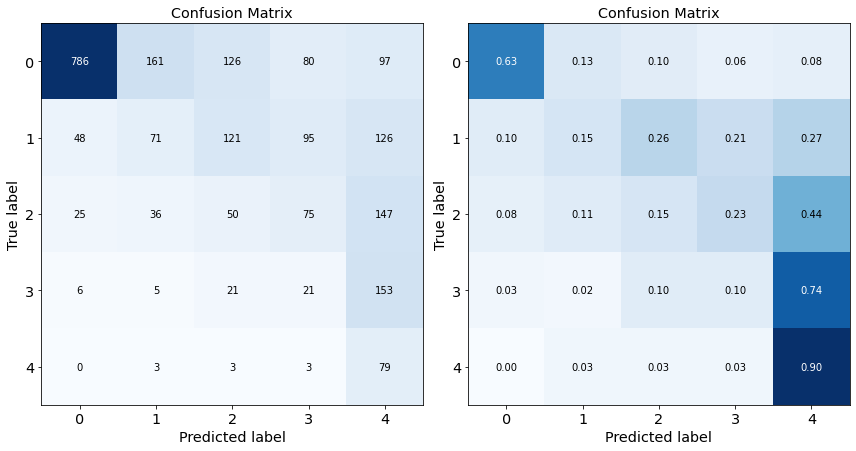

In [114]:
plot_conf_mat(conf_mat,['0','1','2','3','4','5'])